<a href="https://colab.research.google.com/github/HeshanNavindu-7/Pneumonia-Detection/blob/main/pneumonia_detection_CheXNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heshannavindu
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images


100%|██████████| 1.17G/1.17G [00:19<00:00, 64.2MB/s]


In [4]:
import os
import random
import matplotlib.pyplot as plt
import cv2

#define path
dataset_dir="/content/labeled-chest-xray-images/chest_xray"
class_count={}
for detection_class in os.listdir(dataset_dir):
  print(detection_class)
  class_dir= os.path.join(dataset_dir,detection_class)
  if os.path.isdir(class_dir):
    num_images=len(os.listdir(class_dir))
    class_count[detection_class]=num_images




train
test


Train Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


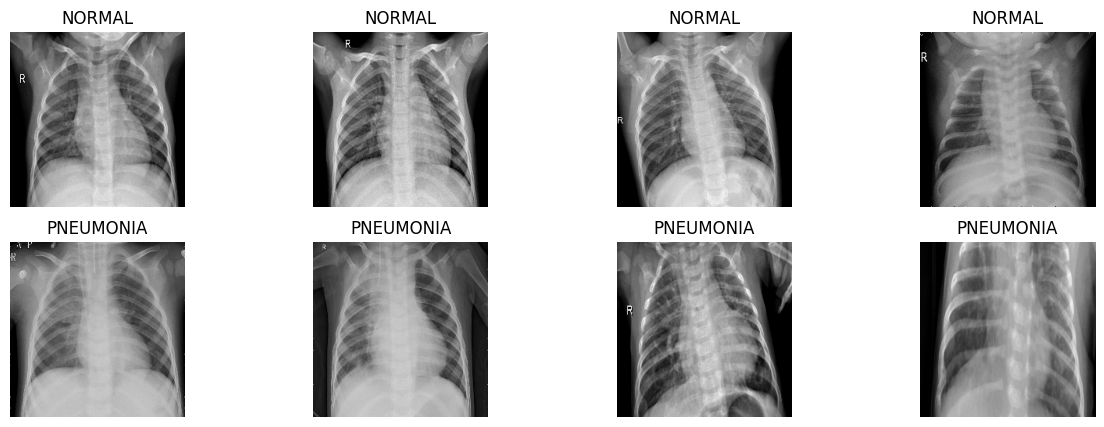

Test Data
Displaying 4 samples from 'NORMAL' class:
Displaying 4 samples from 'PNEUMONIA' class:


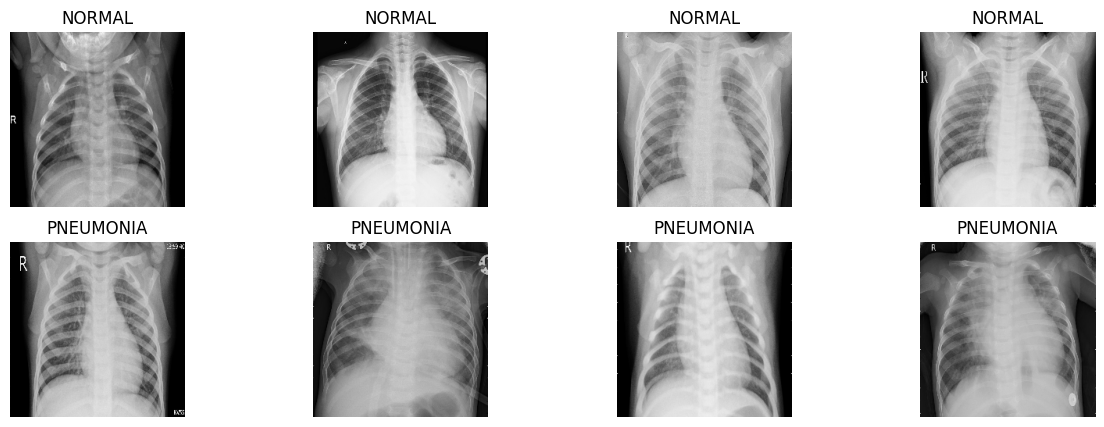

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os

# Define subdirectories for train and test data
train_dir = '/content/labeled-chest-xray-images/chest_xray/train'
test_dir = '/content/labeled-chest-xray-images/chest_xray/test'

# Define image size and batch size
target_size = (224, 224)  # Adjusted to 224x224
batch_size = 32

# Define classes
classes = ['NORMAL', 'PNEUMONIA']

# Display sample data
def display_sample(directory, num_samples=4):
    fig, axs = plt.subplots(len(classes), num_samples, figsize=(15, 5))
    for i, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        print(f"Displaying {num_samples} samples from '{class_name}' class:")

        for j, filename in enumerate(os.listdir(class_dir)):
            if j >= num_samples:
                break
            img_path = os.path.join(class_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, target_size)  # Resize image
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            axs[i, j].set_title(class_name)
    plt.show()

print("Train Data")
display_sample(train_dir)
print("Test Data")
display_sample(test_dir)

In [6]:
# Custom Dataset Class with Data Augmentation
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = classes
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.root_dir, class_name)
            for filename in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, filename))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define data augmentation transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define standard transformations for test dataset (without augmentation)
test_transform = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders with augmentation
train_dataset = ChestXRayDataset(train_dir, transform=train_transform)
test_dataset = ChestXRayDataset(test_dir, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [8]:
import torch
import torch.nn as nn
import torchvision.models as models

# Define the model (example with CheXNet)
class CheXNet(nn.Module):
    def __init__(self, num_classes=2):
        super(CheXNet, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.densenet(x)
        return x

# Instantiate the model
model = CheXNet(num_classes=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print model architecture and number of parameters
print(model)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Example of input size (assuming 3 channels RGB and size 224x224)
input_example = torch.randn(1, 3, 224, 224).to(device)
output_example = model(input_example)
print(f"Output shape: {output_example.shape}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 46.1MB/s]


CheXNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

In [9]:
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [17]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the number of epochs
num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)  # Move inputs to GPU if available
        labels = labels.to(device)  # Move labels to GPU if available

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
   # Print loss value before backpropagation
        print(f'Epoch {epoch+1}/{num_epochs}, Step Loss: {loss.item()}')
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

# Evaluation loop
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_corrects = 0

with torch.no_grad():  # No need to calculate gradients during evaluation
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Statistics
        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)

    test_loss = test_loss / len(test_dataset)
    test_acc = test_corrects.double() / len(test_dataset)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')


Epoch 1/1, Step Loss: 0.15200334787368774
Epoch 1/1, Step Loss: 0.4514399766921997
Epoch 1/1, Step Loss: 0.055914342403411865
Epoch 1/1, Step Loss: 0.08107829838991165
Epoch 1/1, Step Loss: 0.2918068766593933
Epoch 1/1, Step Loss: 0.14531640708446503
Epoch 1/1, Step Loss: 0.10926204919815063
Epoch 1/1, Step Loss: 0.32728052139282227
Epoch 1/1, Step Loss: 0.2110215276479721
Epoch 1/1, Step Loss: 0.03177165240049362
Epoch 1/1, Step Loss: 0.11442608386278152
Epoch 1/1, Step Loss: 0.07722654938697815
Epoch 1/1, Step Loss: 0.029355214908719063
Epoch 1/1, Step Loss: 0.037456344813108444
Epoch 1/1, Step Loss: 0.19113995134830475
Epoch 1/1, Step Loss: 0.23054859042167664
Epoch 1/1, Step Loss: 0.08841807395219803
Epoch 1/1, Step Loss: 0.08039584010839462
Epoch 1/1, Step Loss: 0.18533502519130707
Epoch 1/1, Step Loss: 0.17423002421855927
Epoch 1/1, Step Loss: 0.22387997806072235
Epoch 1/1, Step Loss: 0.06443262845277786
Epoch 1/1, Step Loss: 0.16717639565467834
Epoch 1/1, Step Loss: 0.2079194486

In [18]:
torch.save(model.state_dict(), 'chexnet_pneumonia.pth')


In [19]:
model.load_state_dict(torch.load('chexnet_pneumonia.pth'))
model.eval()  # Set the model to evaluation mode


CheXNet(
  (densenet): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.

In [23]:
import torch

def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    correct_preds = 0
    total_preds = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            total_loss += criterion(outputs, labels).item()
            correct_preds += torch.sum(preds == labels).item()
            total_preds += labels.size(0)

    # Calculate accuracy and average loss
    accuracy = correct_preds / total_preds * 100.0
    average_loss = total_loss / len(dataloader)

    return accuracy, average_loss


In [25]:
# Example usage for test set
test_accuracy, test_loss = evaluate_model(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}')


Test Accuracy: 94.39%, Test Loss: 0.1545


In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 6.0 MB/s eta 0:00:00


In [29]:
from sklearn.metrics import confusion_matrix

def evaluate_model(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    running_corrects = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Statistics
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Collect predictions and ground truths for confusion matrix
            predictions.extend(preds.cpu().numpy())
            ground_truths.extend(labels.cpu().numpy())

    # Calculate average loss and accuracy
    loss = running_loss / len(dataloader.dataset)
    accuracy = running_corrects.double() / len(dataloader.dataset)

    # Print or log metrics
    print(f'Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')

    # Calculate confusion matrix
    cm = confusion_matrix(ground_truths, predictions)
    return accuracy.item(), loss.item(), cm


In [30]:
# Example usage for validation set
val_accuracy, val_loss, val_cm = evaluate_model(model, val_loader, criterion, device)
print(f'Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {val_loss:.4f}')
print('Confusion Matrix:')
print(val_cm)

# Example usage for test set
test_accuracy, test_loss, test_cm = evaluate_model(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.4f}')
print('Confusion Matrix:')
print(test_cm)



NameError: name 'val_loader' is not defined